In [17]:
# from pyspark.sql import SparkSession
import glob
import numpy as np
import pandas as pd
import os
import concurrent.futures
from tqdm import tqdm
import matplotlib.pyplot as plt

In [18]:
#Set Environment accordingly
os.environ['JAVA_HOME'] = "/Library/Java/JavaVirtualMachines/adoptopenjdk-8.jdk/Contents/Home/"
os.environ['SPARK_HOME'] = "/Users/simran/Downloads/spark-3.5.5-bin-hadoop3/"

In [19]:
directory_path = "./data/full_history"
file_pattern = "*.csv"

In [4]:

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("BigDataProject1") \
    .config("spark.driver.bindAddress", "127.0.0.1") \
    .config("spark.executor.memory", "12g") \
    .config("spark.driver.memory", "15g") \
    .config("spark.driver.maxResultSize", "4g") \
    .config("spark.memory.offHeap.enabled", True) \
    .config("spark.memory.offHeap.size", "20g") \
    .config("spark.default.parallelism", "100") \
    .config("spark.sql.shuffle.partitions", "200") \
    .config("spark.executor.extraJavaOptions", "-XX:+UseG1GC") \
    .config("spark.serializer", "org.apache.spark.serializer.JavaSerializer") \
    .getOrCreate()


25/05/03 14:17:30 WARN Utils: Your hostname, Simrans-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.222 instead (on interface en0)
25/05/03 14:17:30 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/03 14:17:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, DateType

schema = StructType([
    StructField("date", DateType(), True),
    StructField("volume", DoubleType(), True),  
    StructField("open", DoubleType(), True),
    StructField("high", DoubleType(), True),
    StructField("low", DoubleType(), True),
    StructField("close", DoubleType(), True),
    StructField("adj close", DoubleType(), True),
    StructField("StockName", StringType(), True)
])

In [6]:
# Load datasets as DataFrames
history_df = spark.read.format("csv") \
     .option("header", "true") \
     .option("treatEmptyValuesAsNulls", "true") \
     .option("schema",schema) \
     .load(f"{directory_path}/{file_pattern}")


history_df.show(5)

+----------+-------+-----------------+------------------+------------------+------------------+------------------+---------+
|      date| volume|             open|              high|               low|             close|         adj close|StockName|
+----------+-------+-----------------+------------------+------------------+------------------+------------------+---------+
|2023-12-28|5703600|30.14999961853028|30.239999771118164|29.950000762939453| 30.18000030517578| 30.18000030517578|      HPQ|
|2023-12-27|5127900|30.39999961853028|30.520000457763672|30.209999084472656|30.239999771118164|30.239999771118164|      HPQ|
|2023-12-26|4853600|30.13999938964844|30.549999237060547|30.059999465942383| 30.40999984741211| 30.40999984741211|      HPQ|
|2023-12-22|4476400|30.21999931335449|30.479999542236328| 30.06999969482422| 30.18000030517578| 30.18000030517578|      HPQ|
|2023-12-21|6529200|30.07999992370605| 30.21999931335449| 29.90999984741211| 30.13999938964844| 30.13999938964844|      HPQ|


In [7]:
# Remove duplicates
history_df = history_df.dropDuplicates()

# Handle missing values for both open and close simultaneously
history_df = history_df.na.fill({
    "open": np.nan,
    "close": np.nan
})
history_df = history_df.replace(float('nan'), None)

history_df.cache()


DataFrame[date: string, volume: string, open: string, high: string, low: string, close: string, adj close: string, StockName: string]

In [8]:
history_df.describe().show()

25/05/03 14:20:00 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+----------+--------------------+--------+--------------------+--------------------+--------+--------------------+---------+
|summary|      date|              volume|    open|                high|                 low|   close|           adj close|StockName|
+-------+----------+--------------------+--------+--------------------+--------------------+--------+--------------------+---------+
|  count|  29675300|            29675043|29675300|            29675043|            29675043|29675300|            29675043| 29675300|
|   mean|      NULL|  1218955.7366696654|     NaN|1.538009260333542E10|1.469882232555163...|     NaN|-5.88525798081733...|      NaN|
| stddev|      NULL|1.2938394989509307E7|     NaN|2.937609262009877...|2.811944953441444...|     NaN|9.950828002441017E18|      NaN|
|    min|1962-01-02|                   0|       0|                 0.0|                 0.0|     0.0|                -0.0|        A|
|    max|2023-12-28|            99999600|     NaN|              9999.

In [9]:
history_df.count()


29675300

In [42]:
#Convert Data to Pandas DataFrame to plot visualisations

all_files = glob.glob("./data/full_history/*.csv")

history_df_pd = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)



In [43]:
history_df_pd.head()

,date,volume,open,high,low,close,adj close,StockName
0,2023-12-28,196100.0,11.06,11.100,10.930,11.00,11.00,RIV
1,2023-12-27,64900.0,11.09,11.150,11.090,11.11,11.11,RIV
2,2023-12-26,180600.0,11.13,11.149,10.975,11.13,11.13,RIV
3,2023-12-22,100700.0,11.15,11.200,11.110,11.12,11.12,RIV
4,2023-12-21,68400.0,11.32,11.320,11.140,11.19,11.19,RIV


In [49]:
print(history_df_pd['date'].dtype)

object


In [60]:
#Data Visualisations

#Time series visualisation given stock name

# import matplotlib.pyplot as plt
# import ipywidgets as widgets
# import matplotlib.dates as mdate
# from IPython.display import display


# # Create the dropdown widget
# dropdown = widgets.Dropdown(
#     options=sorted(list(history_df_pd['StockName'].unique())),
#     description='StockNames:'
# )

# # Function to update the plot based on dropdown selection
# def update_plot(category):
#     plt.clf() # Clear previous plot
#     filtered_df = history_df_pd[history_df_pd['StockName'] == category]
#     filtered_df.loc[:,'date'] = pd.to_datetime(filtered_df['date'])
#     # Plotting closing prices for a single stock
#     sorted_filtered_df = filtered_df.sort_values(by='date')
#     plt.plot(sorted_filtered_df['date'], sorted_filtered_df['close'])
#     plt.title(f'Plot for {category}')
#     plt.xlabel('Time')
#     plt.ylabel('Price')
#     locator = mdate.YearLocator()
#     plt.gca().xaxis.set_major_locator(locator)

#     plt.gcf().autofmt_xdate()


# # Observe the dropdown value and update the plot
# out = widgets.interactive_output(update_plot, {'category': dropdown})

# # Display the dropdown and the initial plot

# display(dropdown, out)

import plotly.graph_objs as go
import pandas as pd
import ipywidgets as widgets
from IPython.display import display

# Assume history_df_pd is your DataFrame with columns: 'StockName', 'date', 'close'

# Create the dropdown widget
dropdown = widgets.Dropdown(
    options=sorted(list(history_df_pd['StockName'].unique())),
    description='StockNames:'
)

# Create a FigureWidget
fig = go.FigureWidget()

def update_plot(category):
    filtered_df = history_df_pd[history_df_pd['StockName'] == category].copy()
    filtered_df['date'] = pd.to_datetime(filtered_df['date'])
    filtered_df = filtered_df.sort_values(by='date')
    with fig.batch_update():
        fig.data = []  # Clear previous traces
        fig.add_scatter(x=filtered_df['date'].astype(dtype=str), y=filtered_df['close'], mode='lines', name = category)
        fig.layout.title = f'Plot for {category}'
        fig.layout.xaxis.title = 'Time'
        fig.layout.yaxis.title = 'Price'
        # fig.update_layout(xaxis_type='date')
        # fig.update_xaxes(tickformat="%Y-%m-%d")

# Link the dropdown to the update function
dropdown.observe(lambda change: update_plot(change['new']), names='value')

# Display the dropdown and the plot
display(dropdown, fig)

# Initialize with the first option
update_plot(dropdown.value)

Dropdown(description='StockNames:', options=('A', 'AA', 'AAAU', 'AACG', 'AADR', 'AAL', 'AAMC', 'AAME', 'AAN', …

FigureWidget({
    'data': [], 'layout': {'template': '...'}
})

In [61]:
#Data Visualisations

#Moving Averages visualisation given stock name


# Create the dropdown widget
dropdown = widgets.Dropdown(
    options=sorted(list(history_df_pd['StockName'].unique())),
    description='StockNames:'
)

# Create Plotly FigureWidget
fig = go.FigureWidget()

def update_plot(category):
    filtered_df = history_df_pd[history_df_pd['StockName'] == category].copy()
    filtered_df['date'] = pd.to_datetime(filtered_df['date'])
    filtered_df = filtered_df.sort_values(by='date')
    filtered_df['ma100'] = filtered_df['close'].rolling(100).mean()
    
    with fig.batch_update():
        fig.data = []  # Clear previous traces
        fig.add_scatter(
            x=filtered_df['date'].astype(dtype=str),
            y=filtered_df['close'],
            mode='lines',
            name='Close Price',
            line=dict(color='blue')
        )
        fig.add_scatter(
            x=filtered_df['date'].astype(dtype=str),
            y=filtered_df['ma100'],
            mode='lines',
            name='100-Day MA',
            line=dict(color='red')
        )
        fig.layout.title = f"{category} Price with 100-Day MA"
        fig.layout.xaxis.title = 'Date'
        fig.layout.yaxis.title = 'Price'
        # fig.layout.xaxis.tickformat = '%Y'
        # fig.layout.xaxis.dtick = 'M12'

def on_dropdown_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        update_plot(change['new'])

dropdown.observe(on_dropdown_change, names='value')

display(dropdown, fig)
update_plot(dropdown.value)  # Show initial plot

Dropdown(description='StockNames:', options=('A', 'AA', 'AAAU', 'AACG', 'AADR', 'AAL', 'AAMC', 'AAME', 'AAN', …

FigureWidget({
    'data': [], 'layout': {'template': '...'}
})

In [62]:
dropdown_ma = widgets.Dropdown(
    options=sorted(list(history_df_pd['StockName'].unique())),
    description='Stock:',
    style={'description_width': 'initial'}
)

fig_ma = go.FigureWidget()

def update_ma(stock):
    stock_data = history_df_pd[history_df_pd['StockName'] == stock].copy()
    stock_data['date'] = pd.to_datetime(stock_data['date'])
    stock_data = stock_data.sort_values(by='date')
    
    # Calculate moving averages
    stock_data['MA7'] = stock_data['close'].rolling(7).mean()
    stock_data['MA21'] = stock_data['close'].rolling(21).mean()
    
    with fig_ma.batch_update():
        fig_ma.data = []
        fig_ma.add_trace(go.Scatter(
            x=stock_data['date'].astype(dtype=str), 
            y=stock_data['close'], 
            mode='lines', 
            name='Close Price'
        ))
        fig_ma.add_trace(go.Scatter(
            x=stock_data['date'].astype(dtype=str), 
            y=stock_data['MA7'], 
            mode='lines', 
            line=dict(dash='dot', color='orange'), 
            name='7-Day MA'
        ))
        fig_ma.add_trace(go.Scatter(
            x=stock_data['date'].astype(dtype=str), 
            y=stock_data['MA21'], 
            mode='lines', 
            line=dict(dash='dash', color='green'), 
            name='21-Day MA'
        ))
        fig_ma.update_layout(
            title=f'Price and Moving Averages - {stock}',
            xaxis_title='Date',
            yaxis_title='Price'
        )

dropdown_ma.observe(lambda change: update_ma(change['new']), names='value')
display(dropdown_ma, fig_ma)
update_ma(dropdown_ma.value)

Dropdown(description='Stock:', options=('A', 'AA', 'AAAU', 'AACG', 'AADR', 'AAL', 'AAMC', 'AAME', 'AAN', 'AAOI…

FigureWidget({
    'data': [], 'layout': {'template': '...'}
})

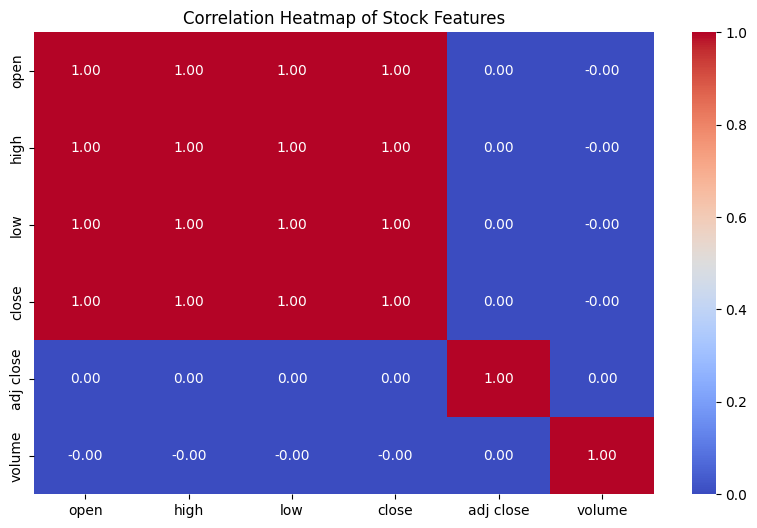

In [24]:
# Correlation Heatmap
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = history_df_pd[['open', 'high', 'low', 'close', 'adj close', 'volume']].corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Stock Features")
plt.show()


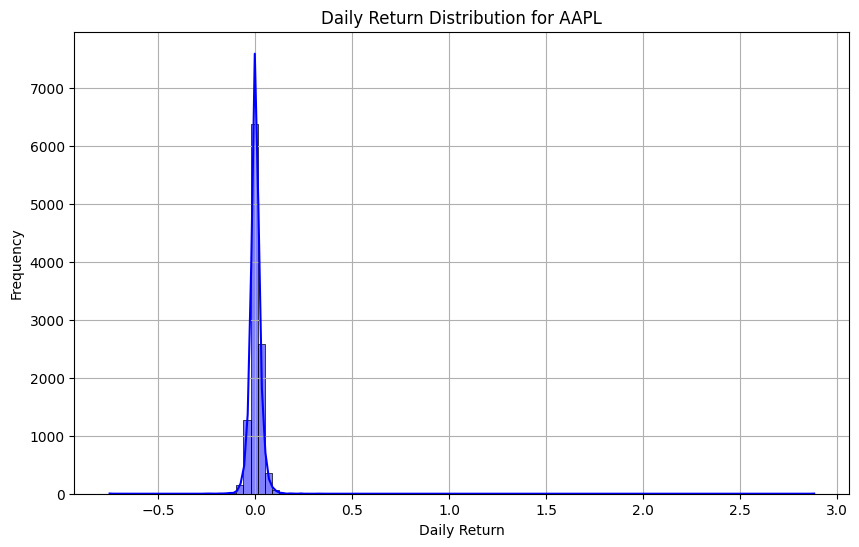

In [25]:
#Daily Returns Distribution

stock = 'AAPL'  # Replace with desired stock
df = history_df_pd[history_df_pd['StockName'] == stock].copy()
df = df.sort_values(by='date')
df['daily_return'] = df['close'].pct_change()

plt.figure(figsize=(10, 6))
sns.histplot(df['daily_return'].dropna(), bins=100, kde=True, color='blue')
plt.title(f"Daily Return Distribution for {stock}")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [26]:
import plotly.graph_objs as go
import pandas as pd

df = history_df_pd.copy()
df['daily_return'] = df.groupby('StockName')['close'].pct_change()
volatility = df.groupby('StockName')['daily_return'].std().sort_values(ascending=False).head(10)

fig = go.Figure(data=[
    go.Bar(
        x=volatility.index,
        y=volatility.values,
        marker_color='crimson'
    )
])
fig.update_layout(
    title="Top 10 Most Volatile Stocks (Std Dev of Daily Returns)",
    xaxis_title="Stock",
    yaxis_title="Volatility",
    xaxis_tickangle=45,
    bargap=0.3
)
fig.show()


/var/folders/n5/73xqm37j4fd6v593l0bz13680000gn/T/ipykernel_40555/260791014.py:5: FutureWarning:

The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.



In [63]:
import plotly.graph_objs as go
import ipywidgets as widgets
from IPython.display import display

# Create dropdown widget
dropdown = widgets.Dropdown(
    options=sorted(list(history_df_pd['StockName'].unique())),
    description='Stock:',
    style={'description_width': 'initial'}
)

# Create figure widget
fig = go.FigureWidget()

def update_candlestick(stock):
    # Filter data for selected stock
    stock_data = history_df_pd[history_df_pd['StockName'] == stock].copy()
    stock_data['date'] = pd.to_datetime(stock_data['date'])
    stock_data = stock_data.sort_values(by='date')
    
    with fig.batch_update():
        fig.data = []  # Clear previous traces
        fig.add_trace(go.Candlestick(
            x=stock_data['date'].astype(dtype=str),
            open=stock_data['open'],
            high=stock_data['high'],
            low=stock_data['low'],
            close=stock_data['close'],
            name=stock
        ))
        fig.update_layout(
            title=f'Price Action and Market Sentiment - {stock}',
            xaxis_title='Date',
            yaxis_title='Price',
            xaxis_rangeslider_visible=False
        )

# Link dropdown to update function
dropdown.observe(lambda change: update_candlestick(change['new']), names='value')

# Display dropdown and figure
display(dropdown, fig)

# Initialize with first stock
update_candlestick(dropdown.value)


Dropdown(description='Stock:', options=('A', 'AA', 'AAAU', 'AACG', 'AADR', 'AAL', 'AAMC', 'AAME', 'AAN', 'AAOI…

FigureWidget({
    'data': [], 'layout': {'template': '...'}
})

In [64]:
history_df_pd['daily_return'] = history_df_pd.groupby('StockName')['close'].pct_change()

dropdown_hist = widgets.Dropdown(
    options=sorted(list(history_df_pd['StockName'].unique())),
    description='Stock:',
    style={'description_width': 'initial'}
)

fig_hist = go.FigureWidget()

def update_histogram(stock):
    stock_data = history_df_pd[history_df_pd['StockName'] == stock].copy()
    stock_data = stock_data.dropna(subset=['daily_return'])
    
    with fig_hist.batch_update():
        fig_hist.data = []
        fig_hist.add_trace(go.Histogram(
            x=stock_data['daily_return'],
            nbinsx=20,
            marker_color='green'
        ))
        fig_hist.update_layout(
            title=f'Daily Returns Distribution - {stock}',
            xaxis_title='Daily Return',
            yaxis_title='Frequency'
        )

dropdown_hist.observe(lambda change: update_histogram(change['new']), names='value')
display(dropdown_hist, fig_hist)
update_histogram(dropdown_hist.value)

/var/folders/n5/73xqm37j4fd6v593l0bz13680000gn/T/ipykernel_40555/2577957069.py:1: FutureWarning:

The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.



Dropdown(description='Stock:', options=('A', 'AA', 'AAAU', 'AACG', 'AADR', 'AAL', 'AAMC', 'AAME', 'AAN', 'AAOI…

FigureWidget({
    'data': [], 'layout': {'template': '...'}
})